In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, random_split
import torchmetrics
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2 as cv
import seaborn as sns

import os
import segmentation_models_pytorch as smp

A:\Jupyter Files\envs\visual\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
JSON_FILE = r"HuBMAP dataset\polygons.jsonl"
IMG_PATH = r"HuBMAP dataset\imgs"
TILE_META_PATH = r"HuBMAP dataset\tile_meta.csv"

MODEL_PATH = r"models\cv\best__wsi1.pt"

SEED = 42

## MODEL EVALUATION

In this notebook, we will evaluate the UNet model, trained on WSIs #2, #3 and #4, using data from WSI #1.

In [4]:
def show_masked(img, mask, ax):
    mask_full = np.zeros_like(img, dtype=np.uint8)
    mask_full[:,:,0] = mask
    masked_img = cv.bitwise_or(img, mask_full)
    return ax.imshow(masked_img)


def img_denorm(x):
    x = x + np.abs(x.min())
    x = x/x.max()
    x = x * 255
    x = x.astype(np.uint8)

    return x

First, let's prepare and take a look at the data.

In [5]:
class HubmapDataset(Dataset):

    def __init__(self, json_file=JSON_FILE,
                 images_path=IMG_PATH,
                 tile_meta_path=TILE_META_PATH,
                 wsi_n=1,
                 test=True,
                 return_stack=False):

        self.test = test
        self.wsi_n = wsi_n
        self.tile_meta = tile_meta_path
        self.polygons = json_file
        self.images_path = images_path
        self.return_stack = return_stack

    def __len__(self):
        return len(self.polygons)

    @property
    def tile_meta(self):
        return self.__tile_meta

    @tile_meta.setter
    def tile_meta(self, val):
        with open(val) as f:
            tile_file = pd.read_csv(f)
            if self.test:
                tile_file = tile_file[tile_file.source_wsi == self.wsi_n].reset_index(drop=True)
            else:
                tile_file = tile_file[tile_file.source_wsi.isin([n for n in [1,2,3,4] if n!=self.wsi_n])].reset_index(drop=True)
            self.__tile_meta = tile_file

    @property
    def polygons(self):
        return self.__polygons

    @polygons.setter
    def polygons(self, val):
        with open(val) as f:
            polygons = pd.read_json(f, lines=True)
            polygons = polygons[polygons.id.isin(self.tile_meta.id)].reset_index(drop=True)
            self.__polygons = polygons

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= len(self):
            raise StopIteration
        img, msk, msk_stk, n_cls = self[self.i]

        self.i += 1

        return img, msk, msk_stk, n_cls

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        img_name = os.path.join(self.images_path,
                               self.polygons.iloc[index, 0])

        image = Image.open(img_name+'.tif')

        n_instances = len(self.polygons.annotations[index])

        self.mask_stack = np.zeros((n_instances, 512, 512), dtype=np.uint8)
        self.n_classes = np.zeros(3, dtype=np.uint8)

        for n, coord_dict in enumerate(self.polygons.annotations[index]):
            if coord_dict['type'] == 'blood_vessel':
                polygons = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(self.mask_stack[n], pts=[polygons], color=1)
                self.n_classes[0] += 1

            if coord_dict['type'] == 'glomerulus':
                polygons = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(self.mask_stack[n], pts=[polygons], color=2)
                self.n_classes[1] += 1

            # if coord_dict['type'] == 'unsure':
            #     polygons = np.array(coord_dict['coordinates'][0])
            #     cv.fillPoly(self.mask_stack[n], pts=[polygons], color=3)


        mask = self.mask_stack[0]
        for i in range(1, n_instances):
            mask = cv.bitwise_xor(mask, self.mask_stack[i])
        mask[np.isnan(mask)] = 0

        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        image = np.array(image)/255

        image = image.transpose((2,0,1)).astype(np.float32)
        image = norm(torch.tensor(image))
        mask = mask.astype(np.float32)

        sample = (image, mask)

        if self.return_stack:
            return (image, mask, self.mask_stack, self.n_classes)

        return sample

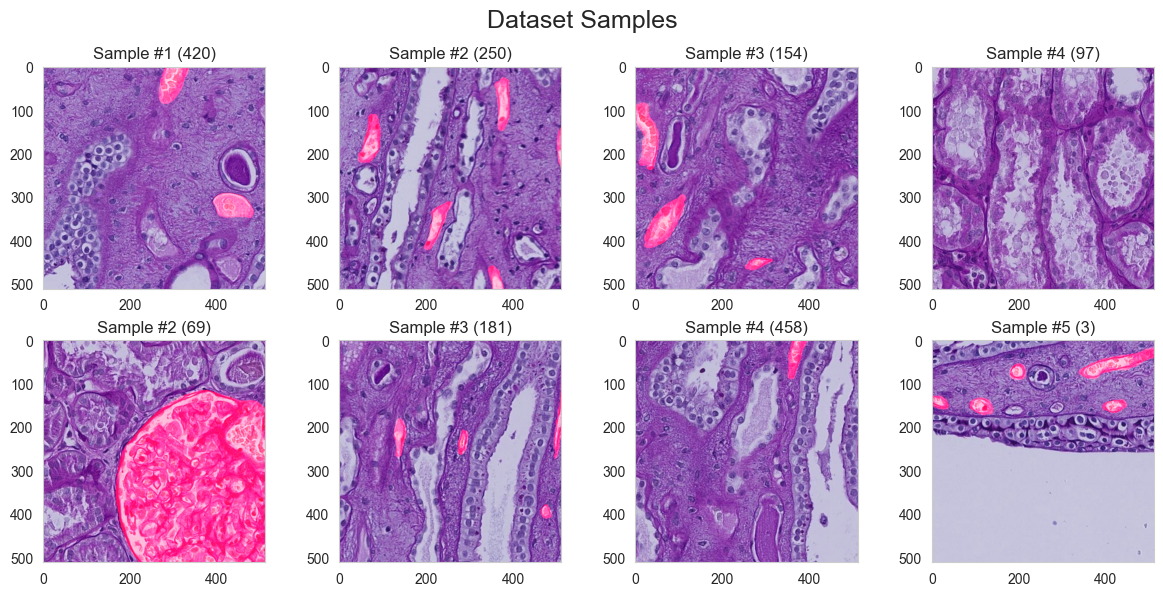

In [101]:
sample_data = HubmapDataset(return_stack=False)
n_rows = 2
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,6), layout='tight')

for i in range(n_rows):
    for j in range(n_cols):
        n = np.random.randint(0, len(sample_data))

        img, mask = sample_data[n]

        show_masked((img_denorm(img.detach().numpy().transpose(1,2,0))),
                               (mask.squeeze()*255).astype('uint8'),
                               axs[i,j])
        axs[i,j].set_title(f'Sample #{i+j+1} ({n})')
        axs[i, j].grid(False)

fig.suptitle('Dataset Samples', fontsize=18)
plt.show()

Importing the model.

In [6]:
model = smp.Unet(encoder_name='mit_b4',
                encoder_weights='imagenet',
                decoder_channels=[512, 256, 128, 64, 32],
                decoder_use_batchnorm=True,
                classes=3,
                activation=None)

model.segmentation_head[2] = nn.Softmax(dim=1)

model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

Let's take a look at model's predictions.

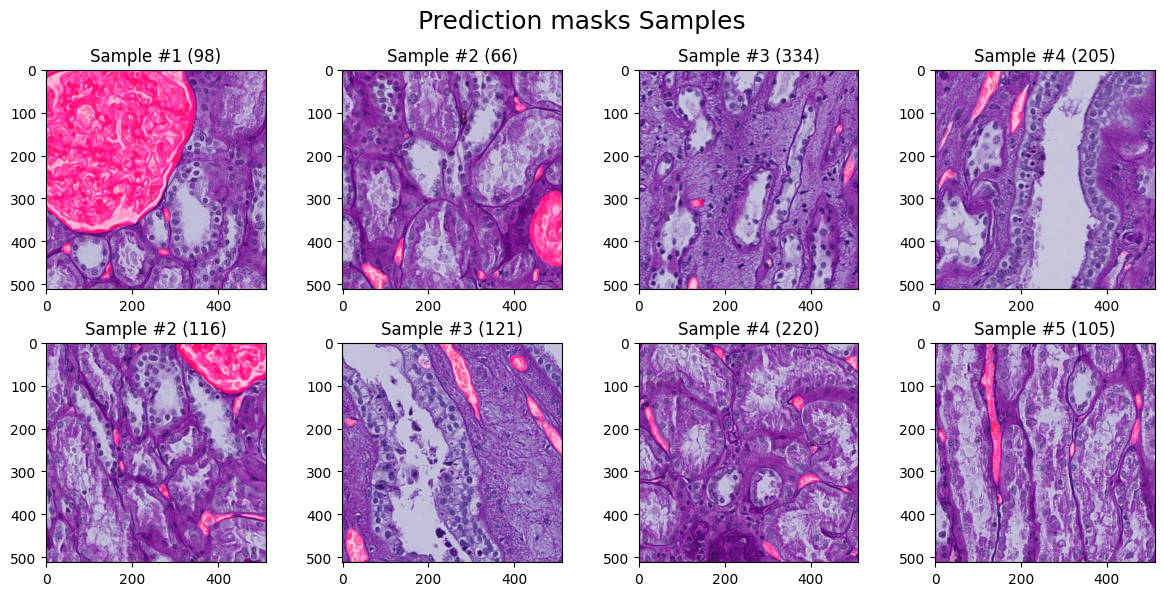

In [10]:
n_rows = 2
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,6), layout='tight')
model.eval()

for i in range(n_rows):
    for j in range(n_cols):
        n = np.random.randint(0, len(sample_data))

        img, mask = sample_data[n]

        mask_pred = model(torch.unsqueeze(img, dim=0))

        mask_pred = mask_pred.detach().numpy().squeeze()
        mask_sum = mask_pred[1] + mask_pred[2]

        show_masked((img_denorm(img.detach().numpy().transpose(1,2,0))),
                               (mask_sum.squeeze()*255).astype('uint8'),
                               axs[i,j])
        axs[i,j].set_title(f'Sample #{i+j+1} ({n})')
        axs[i, j].grid(False)

fig.suptitle('Prediction masks Samples', fontsize=18)
plt.show()

The model's predicting semantic segmentation masks, so we need a function to separate different instances.

In [7]:
def connected_components(pred_mask):

    pred_mask = cv.morphologyEx(pred_mask, cv.MORPH_OPEN, np.ones((7,7),dtype=np.uint8))

    threshold = 0.01

    pred_mask = (pred_mask>threshold).astype(np.uint8)

    labels, labels_id, values, centroid = cv.connectedComponentsWithStats(pred_mask, 4, cv.CV_32S)

    labels = np.array(range(labels))
    predicted_stack = np.zeros((len(labels)-1, pred_mask.shape[0], pred_mask.shape[1]))

    for i in labels[1:]:
            predicted_stack[i-1] = (labels_id == i)

    d = []
    for j, inst in enumerate(predicted_stack):
        if np.sum(inst) < 200:
            d.append(j)

        else:
            predicted_stack[j] = cv.dilate(predicted_stack[j], np.ones((5,5),
                                           dtype=np.uint8), iterations=1)

    predicted_stack = np.delete(predicted_stack, d, axis=0)

    return predicted_stack, labels

Next, we're making predictions and determine, whether an instance was predicted correctly.

In [77]:
def tp_estimation(masks, pred_masks, n_instances):
    classes = np.unique(masks)[1:]
    is_corr = np.array([])
    confidence = np.array([])
    targets = np.array([])

    for cls in classes:
        cls_wise_mask = pred_masks[cls]
        cls_wise_mask = cls_wise_mask/cls_wise_mask.max()
        connected_masks, labels = connected_components(cls_wise_mask)

        n_pred = len(connected_masks)
        n_targ = n_instances[cls-1]
        correct_pred = np.zeros(n_pred)
        conf = np.zeros(n_pred)
        act_cls = np.zeros(n_pred)

        if n_pred:
            for i, instance in enumerate(connected_masks):
                conf[i] = np.nanmean(cls_wise_mask[instance.astype(bool)])
                correct_pred[i] = cls
                if n_targ:
                    for j, msk in enumerate(masks):
                        if msk.max() and iou_metric(torch.tensor(instance), torch.tensor(msk//msk.max())):
                            act_cls[i] = int(msk.max())
                            pred_masks = np.delete(masks, j, axis=0)
                            break

        targets = np.concatenate((targets, act_cls))
        confidence = np.concatenate((confidence, conf))
        is_corr  = np.concatenate((is_corr, correct_pred))

    return is_corr, confidence, targets

In [78]:
test_data = HubmapDataset(return_stack=True)

model.eval()
model.to(device)

n_instances = np.zeros(2)
is_correct = np.array([])
confidence = np.array([])
iou_metric = torchmetrics.JaccardIndex(task='binary', num_classes=1, threshold=0.5)
actual_cls = np.array([])

for image, mask, mask_stack, n_targets in tqdm(test_data):
    image = image.to(device)
    pred_mask_stack = model(torch.unsqueeze(image, dim=0))

    pred_mask_stack = pred_mask_stack.detach().cpu().numpy().squeeze()

    is_correct_list, confidence_list, n = tp_estimation(mask_stack, pred_mask_stack, n_targets)
    actual_cls = np.concatenate((actual_cls, n))

    is_correct = np.concatenate((is_correct, is_correct_list))
    confidence = np.concatenate((confidence, confidence_list))
    n_instances += n_targets[:2]

n_instances = np.concatenate((n_instances, [n_instances.sum()]))
scores_df = pd.DataFrame.from_dict({'conf': confidence, 'pred_cls': is_correct, 'actual_cls': actual_cls})

100%|██████████| 507/507 [01:59<00:00,  4.23it/s]


Let's take a look at the multiclass *Confusion matrix*.

In [79]:
sorted_scores_df = scores_df.sort_values(by='conf', ascending=False).reset_index(drop=True)
sorted_scores_df.conf = sorted_scores_df.conf.round(2)
sorted_scores_df.pred_cls = sorted_scores_df.pred_cls.astype(int)
sorted_scores_df.actual_cls = sorted_scores_df.actual_cls.astype(int)

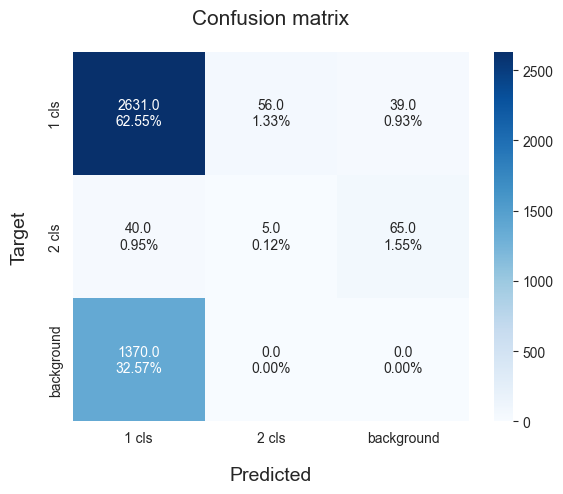

In [99]:
max_index = sorted_scores_df.index[sorted_scores_df.conf == 0.3][-1]
max_indexed_df = sorted_scores_df[:max_index]

pred_1_class_df = max_indexed_df[max_indexed_df.pred_cls == 1]
pred_2_class_df = max_indexed_df[max_indexed_df.pred_cls == 2]

cm = np.array([[len(pred_1_class_df[pred_1_class_df.actual_cls == 1]),
                len(pred_2_class_df[pred_2_class_df.actual_cls == 1]),
                (n_instances[0] - len(pred_1_class_df))],
               [len(pred_1_class_df[pred_1_class_df.actual_cls == 2]),
                len(pred_2_class_df[pred_2_class_df.actual_cls == 2]),
                (n_instances[1] - len(pred_2_class_df))],
               [len(pred_1_class_df[pred_1_class_df.actual_cls == 0]),
                len(pred_2_class_df[pred_2_class_df.actual_cls == 0]),
                0]])

cm_class = ['1 cls', '2 cls', 'background']

cm_labels = [f'{n}\n{n/np.sum(cm):.2%}' for n in cm.flatten()]
cm_labels = np.asarray(cm_labels).reshape(3,3)
fig = sns.heatmap(cm, annot=cm_labels,  fmt='', cmap='Blues', xticklabels=cm_class, yticklabels=cm_class)
fig.set_title('Confusion matrix', fontsize=15, pad=20)
fig.set_xlabel('Predicted', fontsize=14, labelpad=15)
fig.set_ylabel('Target', fontsize=14, labelpad=15)

plt.show()

So, the model is performing poorly on 2 class, but our target class is the 1st one, so let's ignore it for now.
Next, we need to calculate *Prediction* and *Recall* for both classes, and use them to calculate *mAP* and *F1* metrics.

In [89]:
grouped_df_1cls = sorted_scores_df[sorted_scores_df.pred_cls == 1].reset_index(drop=True)
grouped_df_2cls = sorted_scores_df[sorted_scores_df.pred_cls == 2].reset_index(drop=True)

grouped_df_1cls['TP'] = (grouped_df_1cls.pred_cls == grouped_df_1cls.actual_cls).astype(int)
grouped_df_2cls['TP'] = (grouped_df_2cls.pred_cls == grouped_df_2cls.actual_cls).astype(int)

grouped_df_1cls['FP'] = (grouped_df_1cls.pred_cls != grouped_df_1cls.actual_cls).astype(int)
grouped_df_2cls['FP'] = (grouped_df_2cls.pred_cls != grouped_df_2cls.actual_cls).astype(int)

df_1cls = (grouped_df_1cls.groupby('conf').sum().
                   sort_values(by='conf', ascending=False).reset_index())
df_2cls = (grouped_df_2cls.groupby('conf').sum().
                   sort_values(by='conf', ascending=False).reset_index())

df_1cls = df_1cls.drop(['pred_cls', 'actual_cls'], axis=1)
df_2cls = df_2cls.drop(['pred_cls', 'actual_cls'], axis=1)
df_1cls.head(10)

,conf,TP,FP
0,0.93,1,0
1,0.92,0,1
2,0.90,1,0
3,0.88,1,1
4,0.87,3,0
5,0.86,7,0
6,0.85,3,1
7,0.84,7,1
8,0.83,12,0
9,0.82,12,2


In [90]:
grouped_df_1cls = grouped_df_1cls.drop(['pred_cls', 'actual_cls'], axis=1)
grouped_df_2cls = grouped_df_2cls.drop(['pred_cls', 'actual_cls'], axis=1)

# all_cls_df = grouped_df_1cls.set_index('conf').add(grouped_df_2cls.set_index('conf'), fill_value=0).reset_index()
all_cls_df = pd.concat([grouped_df_1cls, grouped_df_2cls])
all_cls_df = (all_cls_df.groupby('conf').sum().
                   sort_values(by='conf', ascending=False).reset_index())

In [92]:
ap = np.zeros(3)
df_list = []

for k, cls_df in enumerate([df_1cls, df_2cls, all_cls_df]):
    precision = np.zeros(len(cls_df))
    recall = np.zeros(len(cls_df))
    f1_score = np.zeros(len(cls_df))

    for i in cls_df.index:
        j=i+1
        precision[i] = cls_df.TP[:j].sum() / (cls_df.TP[:j].sum() + cls_df.FP[:j].sum())
        recall[i] = cls_df.TP[:j].sum() / n_instances[k]
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    cls_df['Precision'] = precision
    cls_df['Recall'] = recall
    cls_df['F1_score'] = f1_score

    df_list.append(cls_df)

    ap[k] = cls_df.Precision.mean()

df_list[0].head(10)

,conf,TP,FP,Precision,Recall,F1_score
0,0.93,1,0,1.000000,0.000245,0.000490
1,0.92,0,1,0.500000,0.000245,0.000490
2,0.90,1,0,0.666667,0.000490,0.000980
3,0.88,1,1,0.600000,0.000735,0.001469
4,0.87,3,0,0.750000,0.001471,0.002935
5,0.86,7,0,0.866667,0.003186,0.006349
6,0.85,3,1,0.842105,0.003922,0.007807
7,0.84,7,1,0.851852,0.005637,0.011200
8,0.83,12,0,0.897436,0.008578,0.016994
9,0.82,12,2,0.886792,0.011520,0.022744


Let's calculate the metrics and build some graphs.

1 cls AP@50: 0.732
1 cls F1 score: 0.651


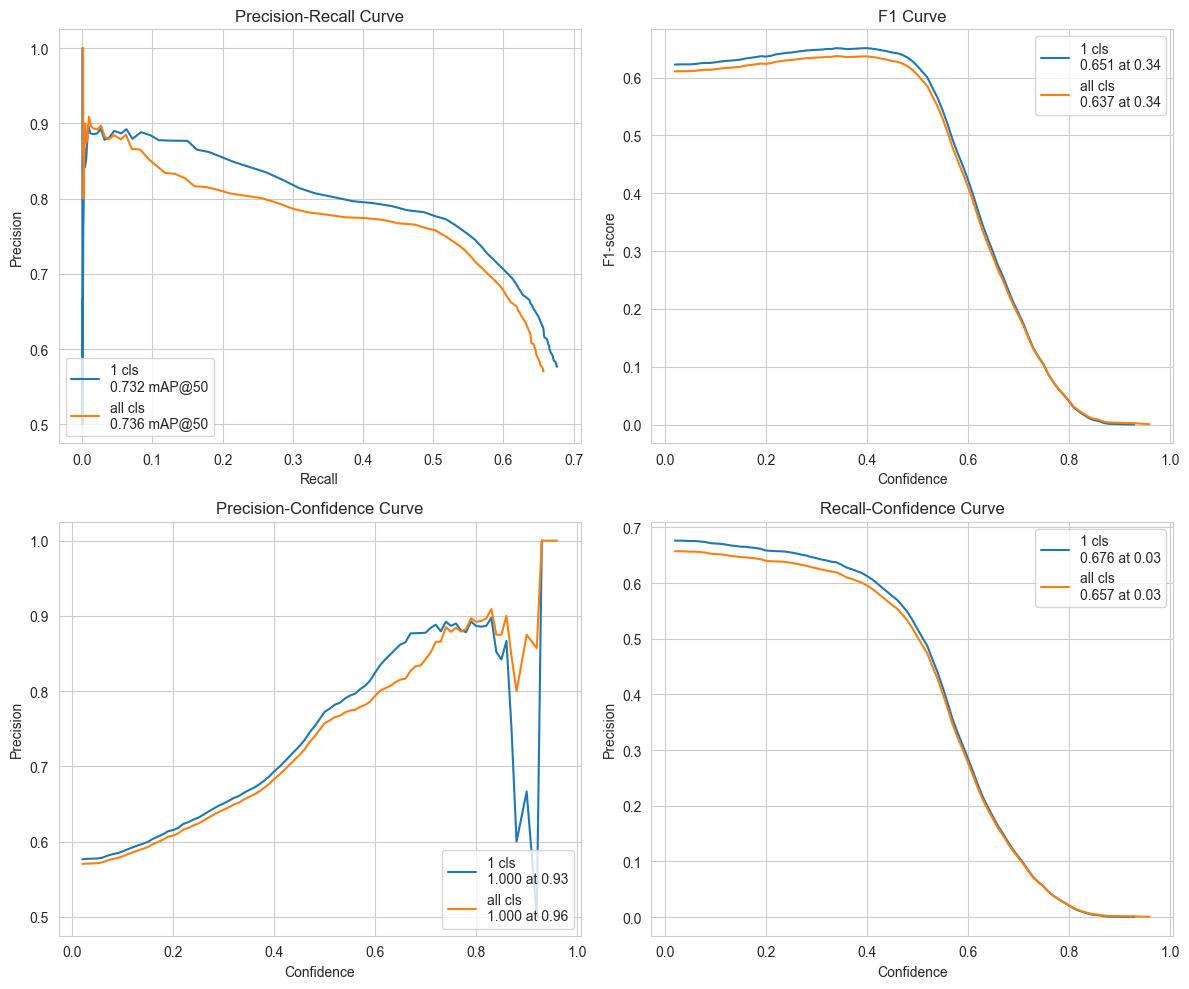

In [102]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), layout='tight')

axs[0,0].plot(df_list[0].Recall, df_list[0].Precision, label=f'1 cls\n{ap[0]:.3f} mAP@50')
axs[0,0].plot(df_list[2].Recall, df_list[2].Precision, label=f'all cls\n{ap[2]:.3f} mAP@50')
axs[0,0].set_xlabel('Recall')
axs[0,0].set_ylabel('Precision')
axs[0,0].set_title('Precision-Recall Curve')
axs[0,0].legend(loc='lower left')

axs[0,1].plot(df_list[0].conf, df_list[0].F1_score, label=f'1 cls\n{df_list[0].F1_score.max():.3f} at \
{df_list[0].conf[df_list[0].F1_score == df_list[0].F1_score.max()].item()}')
axs[0,1].plot(df_list[2].conf, df_list[2].F1_score, label=f'all cls\n{df_list[2].F1_score.max():.3f} at \
{df_list[2].conf[df_list[2].F1_score == df_list[2].F1_score.max()].item()}')
axs[0,1].set_xlabel('Confidence')
axs[0,1].set_ylabel('F1-score')
axs[0,1].set_title('F1 Curve')
axs[0,1].legend(loc='upper right')

axs[1,0].plot(df_list[0].conf, df_list[0].Precision, label=f'1 cls\n{df_list[0].Precision.max():.3f} at \
{df_list[0].conf[df_list[0].Precision == df_list[0].Precision.max()][0]}')
axs[1,0].plot(df_list[2].conf, df_list[2].Precision, label=f'all cls\n{df_list[2].Precision.max():.3f} at \
{df_list[2].conf[df_list[2].Precision == df_list[2].Precision.max()][0]}')
axs[1,0].set_xlabel('Confidence')
axs[1,0].set_ylabel('Precision')
axs[1,0].set_title('Precision-Confidence Curve')
axs[1,0].legend(loc='lower right')

axs[1,1].plot(df_list[0].conf, df_list[0].Recall, label=f'1 cls\n{df_list[0].Recall.max():.3f} at \
{df_list[0].conf[df_list[0].Recall == df_list[0].Recall.max()].values[0]}')
axs[1,1].plot(df_list[2].conf, df_list[2].Recall, label=f'all cls\n{df_list[2].Recall.max():.3f} at \
{df_list[2].conf[df_list[2].Recall == df_list[2].Recall.max()].values[0]}')
axs[1,1].set_xlabel('Confidence')
axs[1,1].set_ylabel('Precision')
axs[1,1].set_title('Recall-Confidence Curve')
axs[1,1].legend(loc='upper right')

print(f'1 cls AP@50: {ap[0]:.3f}\n1 cls F1 score: {df_list[0].F1_score.max():.3f}')
plt.show()

So, the *mAP@50=0.736* and the *F1-score=0.637* over all classes for this model.